# Preparation Section

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from bokeh.plotting import figure, show, output_file
from skimage.morphology import watershed
from skimage.feature import peak_local_max
import torch
from skimage.filters import sobel
from skimage.morphology import watershed

import random
from skimage.feature import canny
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
import sys

if '/scratch/Jack/projects/Chamber' not in sys.path:
    sys.path.insert(0,'/scratch/Jack/projects/Chamber')
if '/scratch/Jack/projects/Explanations' not in sys.path:
    sys.path.insert(0,'/scratch/Jack/projects/Explanations')

from datasets import CustomClusteringDataset
from models import VAE, ConvVAE, W2V

from chamber import Chamber, Misc, Historian, Oracle, Commander

torch.multiprocessing.set_sharing_strategy('file_system')

from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from bokeh.plotting import figure

output_notebook()
opts = dict(plot_width=250, plot_height=250, min_border=0)

historian = Historian()
commander = Commander(historian)
oracle = Oracle(historian)

trainset = CustomClusteringDataset(sizes=(128,128), path="/scratch/datasets/NFLsegment/experiments/vpEB_image_dataset/all_images/",subset=1.0, datasplit=(10,10))
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1, shuffle=True, num_workers=4)

Loading BokehJS ...

# Part Extraction Section

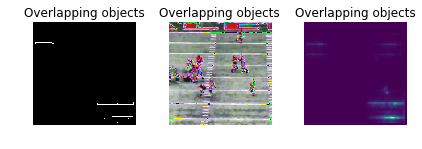

In [3]:
for i, datum in enumerate(trainloader):
    image = datum[1][0][0].numpy()
    
    edges = canny(image)
    fill_coins = ndi.binary_fill_holes(edges)
    label_objects, nb_labels = ndi.label(fill_coins)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > 20
    mask_sizes[0] = 0
    coins_cleaned = mask_sizes[label_objects]
    
    fig, axes = plt.subplots(ncols=3,  sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()

    ax[0].imshow(coins_cleaned, cmap=plt.cm.gray, interpolation='nearest')
    ax[0].set_title('Overlapping objects')
    im = datum[0][0].numpy()
    im = np.swapaxes(im, 0, 2)
    im = np.swapaxes(im, 1, 0)
    ax[1].imshow(im,cmap=plt.cm.gray, interpolation='nearest')
    ax[1].set_title('Overlapping objects')
    ax[2].imshow(datum[1][0][0].numpy(), interpolation='nearest')
    ax[2].set_title('Overlapping objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    break

In [2]:
for i, datum in enumerate(trainloader):
    
    attention_image = datum[1][0][0].numpy()
    original_image = datum[0][0]
    
    markers = np.zeros_like(attention_image)
    thres = 0.0001
    markers[attention_image < thres] = 1
    markers[attention_image >= thres] = 2
    
    elevation_map = sobel(attention_image)
    
    segmentation = watershed(elevation_map, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    
    segmentor, _ = ndi.label(segmentation)
    
    
    
    from bokeh.io import output_file, show
    from bokeh.layouts import column
    from bokeh.plotting import figure
    from bokeh.layouts import row
    orig = torch.clamp(original_image,0,1).numpy()
    orig = np.swapaxes(np.swapaxes(np.multiply(orig,255), 0, 2), 1,0).astype(np.uint8)[::-1]
    orig = np.dstack([orig, 255*np.ones(orig.shape[:2], np.uint8)])
    p = []
    
    p.append(figure(plot_width=124*2, plot_height=128*2, x_range=[0, 128], y_range=[128, 0],  x_axis_location="above",  title=""))
    p[0].image_rgba([orig], x=0, y=128, dw=128, dh=128)
    p.append(figure(plot_width=124*2, plot_height=128*2, x_range=[0, 128], y_range=[128, 0],  x_axis_location="above",  title=""))
    attention_image = attention_image[::-1]
    p[1].image([attention_image], x=0, y=128, dw=128, dh=128)
    segmentor = segmentor[::-1]
    p.append(figure(plot_width=124*2, plot_height=128*2, x_range=[0, 128], y_range=[128, 0],  x_axis_location="above",  title=""))
    p[2].image([segmentor], x=0, y=128, dw=128, dh=128)
    
    print(_)
    seg_threshold = 20
    p_attention_clusters = []
    p_attention_boxes = []
    thres_vis = 0.1
    for i in range(1,_+1):#_):
        seg = np.copy(segmentor)
        att = np.copy(attention_image)
        att[seg != i] = 0
        
        im = np.copy(attention_image)
        im[attention_image == 0] = 0
        im[att == 0] = 0
        
        x_ranges = [128, 0]
        y_ranges = [128, 0]
        for x in range(128):
            for y in range(128):
                if np.sum(im[y,x]) > 0:
                    if x > x_ranges[1]:
                        x_ranges[1] = x
                    if 128-y > y_ranges[1]:
                        y_ranges[1] = 128-y
                    if x < x_ranges[0]:
                        x_ranges[0] = x
                    if 128-y < y_ranges[0]:
                        y_ranges[0] = 128-y
        
        p_attention_clusters.append((figure(plot_width=128*2, plot_height=128*2, x_range=[0, 128], y_range=[128, 0],  x_axis_location="above",  title=""),(x_ranges, y_ranges)))
        dd = np.copy(orig)
        dd[im < thres_vis] = 0
        p_attention_clusters[i-1][0].image([im], x=0, y=128, dw=128, dh=128, alpha=0.2) 
        p_attention_clusters[i-1][0].image_rgba([dd], x=0, y=128, dw=128, dh=128, alpha=0.2) 
        
        p_attention_clusters[i-1][0].quad(x_ranges[0], x_ranges[1], y_ranges[0], y_ranges[1], fill_alpha=0.5)
        if int(np.sum(im)) < seg_threshold:
            p_attention_clusters[i-1] = None
            
    p_attention_cluster_figures = [x[0] for x in p_attention_clusters if x != None]
    p_attention_cluster_ranges = [x[1] for x in p_attention_clusters if x != None]
    
    
    orig_picture_final = figure(plot_width=128*2, plot_height=128*2, x_range=[0, 128], y_range=[128, 0],  x_axis_location="above",  title="")
    orig_picture_final.image_rgba([orig], x=0, y=128, dw=128, dh=128)
    for i in range(len(p_attention_cluster_ranges)):
        x_ranges, y_ranges = p_attention_cluster_ranges[i]
        orig_picture_final.quad(x_ranges[0], x_ranges[1], y_ranges[0], y_ranges[1],line_color="black",fill_color=(random.randint(0,255), random.randint(0,255), random.randint(0,255), 0.3))
        
    

    orig_vanish = np.copy(orig)
    orig_vanish[attention_image < thres_vis] = 0
    orig_vanish[segmentor == 0] = 0
    
    orig_picture_final_extracted = figure(plot_width=128*2, plot_height=128*2, x_range=[0, 128], y_range=[128, 0],  x_axis_location="above",  title="")
    orig_picture_final_extracted.image_rgba([orig_vanish], x=0, y=128, dw=128, dh=128)
    for i in range(len(p_attention_cluster_ranges)):
        x_ranges, y_ranges = p_attention_cluster_ranges[i]
        orig_picture_final_extracted.quad(x_ranges[0], x_ranges[1], y_ranges[0], y_ranges[1],line_color="black",fill_color=(random.randint(0,255), random.randint(0,255), random.randint(0,255), 0.3))
    
    show(column(row(*p),row(*p_attention_cluster_figures),row([orig_picture_final]), row([orig_picture_final_extracted])))
    break

(128, 128)
torch.Size([3, 128, 128])
